In [81]:
import pandas as pd
import numpy as np

* since the mean r2oos of other methods including elastic net, glm, pls, neural network are too small, we only did a dm test on gbrt and rf.

# recreate the train/validation/test split

In [82]:
# import pyarrow.feather as feather
import os
from datetime import datetime
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

## read the feather files

In [83]:
import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

My current directory is : /Users/liuxuyang/Desktop/Summer Project/Data
My directory name is : Data


In [84]:
directory_path = os.getcwd()
data_path = os.path.join(directory_path, 'data')  # the path to data folder

In [85]:
raw_df = pd.read_feather(os.path.join(directory_path, 'chars60_raw_imputed.feather'))

## read the macro data files

In [86]:
macro_df = pd.read_csv(os.path.join(directory_path, 'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [87]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime("%Y%m").apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner', on='yyyymm')
total_df.drop(columns="yyyymm", inplace=True)


In [88]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [89]:
del(raw_tf)

In [90]:
# make a list of unique permno
permno_list = total_df['permno'].unique().tolist()

In [91]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49']
total_df = get_dummy_col(total_df, dummy_col_list)

In [92]:
# set date as the index
total_df.set_index('date', inplace=True)

In [93]:
features_list = total_df.columns.to_list()
list_to_remove = ['gvkey', 'permno', 'ret', 'sic', 'exchcd', 'shrcd']
for element in list_to_remove:
    if element in features_list:
        features_list.remove(element)
        


In [94]:
original_features_list = features_list.copy()

In [95]:
total_df = total_df.sort_index()

# create interaction features(other feature * macro feature)

In [96]:
table_for_interaction = total_df[features_list[:69]]
single_features = features_list[:61]
macro_features = features_list[61:69]

interaction_table = pd.DataFrame(data = None, index = table_for_interaction.index)

from IPython.utils import io
with io.capture_output() as captured: # to ignore warnings
    for i in single_features:
        for j in macro_features:
            interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]

In [97]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
# each_month_permno_num.plot(x='date', y='number_of_permno')

In [98]:
new_total_df = pd.concat([total_df, interaction_table], axis=1)

In [99]:
new_features_list = new_total_df.columns
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd','b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms'}
new_features_list = [ele for ele in new_features_list if ele not in remove_list]

In [100]:
X_total = new_total_df[new_features_list]
y_total = new_total_df['ret']
permno_total = new_total_df['permno']

In [101]:
def train_val_test_preprocess(X_total, y_total, permno_total, training_len, val_len, testing_len):
    """split our data into training set, validation set, and testing set

    Args:
        X_total (dataframe)
        y_total (dataframe)
        training_len (int): length of years of training set
        val_len (int)
        testing_len (int)
    return: dicts:X_train, y_train, X_val, y_val, X_test, y_test
            and a permno series for testing set, which would be part of the result
    """
    X_train_dict = {}
    y_train_dict = {}
    X_val_dict = {}
    y_val_dict = {}
    X_test_dict = {}
    y_test_dict = {}
    permno_test_dict = {}
    first_train_end_year = y_total.index.year[0] + training_len - 1
    total_len = y_total.index.year[-1] - y_total.index.year[0] + 1
    last_train_end_year = first_train_end_year + total_len -(training_len+val_len+testing_len)
    train_end_years = np.arange(first_train_end_year, last_train_end_year+1)
    print('each end year of training set is:', train_end_years)
    for y in tqdm(train_end_years, desc='spliting data', ascii='>>'):
        train_start_year = y - training_len + 1
        train_end_year = y
        val_start_year = y + 1
        val_end_year = val_start_year+val_len-1
        test_start_year= val_end_year+1
        test_end_year = test_start_year+testing_len-1

        print('train start year is', train_start_year)
        print('train end year is', train_end_year)

        print('val start year is', val_start_year)
        print('val end year is', val_end_year)

        print('test start year is', test_start_year)
        print('test end year is', test_end_year)

        tmp_X_train = X_total[(X_total.index.year>=train_start_year) & (X_total.index.year<=train_end_year)]
        tmp_y_train = y_total[(y_total.index.year>=train_start_year) & (y_total.index.year<=train_end_year)]
        tmp_X_val = X_total[(X_total.index.year>=val_start_year) & (X_total.index.year<=val_end_year)]
        tmp_y_val = y_total[(y_total.index.year>=val_start_year) & (y_total.index.year<=val_end_year)]
        tmp_X_test = X_total[(X_total.index.year>=test_start_year) & (X_total.index.year<=test_end_year)]
        tmp_y_test = y_total[(y_total.index.year>=test_start_year) & (y_total.index.year<=test_end_year)]
        tmp_permno_test = permno_total[(permno_total.index.year>=test_start_year) & (permno_total.index.year<=test_end_year)]

        X_train_dict[y] = tmp_X_train
        y_train_dict[y] = tmp_y_train
        X_val_dict[y] = tmp_X_val
        y_val_dict[y] = tmp_y_val
        X_test_dict[y] = tmp_X_test
        y_test_dict[y] = tmp_y_test
        permno_test_dict[y] = tmp_permno_test
    return train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict, permno_test_dict
        

In [102]:
train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict, permno_test_dict = train_val_test_preprocess(X_total, y_total, permno_total, 14, 6, 26)


each end year of training set is: [1985 1986 1987 1988]


spliting data:   0%|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 0/4 [00:00<?, ?it/s]

train start year is 1972
train end year is 1985
val start year is 1986
val end year is 1991
test start year is 1992
test end year is 2017


spliting data:  25%|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 1/4 [00:10<00:31, 10.56s/it]

train start year is 1973
train end year is 1986
val start year is 1987
val end year is 1992
test start year is 1993
test end year is 2018


spliting data:  50%|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 2/4 [00:21<00:21, 10.87s/it]

train start year is 1974
train end year is 1987
val start year is 1988
val end year is 1993
test start year is 1994
test end year is 2019


spliting data:  75%|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 3/4 [00:33<00:11, 11.12s/it]

train start year is 1975
train end year is 1988
val start year is 1989
val end year is 1994
test start year is 1995
test end year is 2020


spliting data: 100%|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 4/4 [00:44<00:00, 11.20s/it]


----------------------------------------------------------

# preprocessing for dm_test
make the data more readable

In [103]:
for y in train_end_years:
    tmp_y_test = y_test_dict[y]
    print(tmp_y_test.index)

DatetimeIndex(['1992-01-31', '1992-01-31', '1992-01-31', '1992-01-31',
               '1992-01-31', '1992-01-31', '1992-01-31', '1992-01-31',
               '1992-01-31', '1992-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=238048, freq=None)
DatetimeIndex(['1993-01-31', '1993-01-31', '1993-01-31', '1993-01-31',
               '1993-01-31', '1993-01-31', '1993-01-31', '1993-01-31',
               '1993-01-31', '1993-01-31',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=235983, freq=None)
DatetimeIndex(['1994-01-31', '1994-01-31', '1994-01-31', '1994-01-

In [104]:
gbrt_result_df = pd.read_pickle('result_data/gbrt_testing26_interaction_result.pkl')
rf_result_df = pd.read_pickle('result_data/rf_testing26_basic_result.pkl')


In [105]:
gbrt_result_df.columns

Index(['year', 'permno', 'y_pred', 'y_real', 'params', 'pred_R2_OOS', 'CV_R2',
       'CV_MSE'],
      dtype='object')

In [106]:
gbrt_result_df

,year,permno,y_pred,y_real,params,pred_R2_OOS,CV_R2,CV_MSE
0,1985,date 1992-01-31 18921 1992-01-31 24942 1...,"[0.009080421151579669, 0.010307980506846882, 0...",date 1992-01-31 -0.043182 1992-01-31 0.02...,"{'learning_rate': 0.0160462998061679, 'max_dep...",0.02867,-0.019174,"[-0.014946945907070505, -0.014638244799527607,..."
1,1986,date 1993-01-31 36003 1993-01-31 25718 1...,"[0.0027396607657490767, 0.03911271501458434, 0...",date 1993-01-31 0.040816 1993-01-31 -0.09...,"{'learning_rate': 0.017588432140324108, 'max_d...",0.01693,-0.026009,"[-0.01372490268936293, -0.013501201756574882, ..."
2,1987,date 1994-01-31 70229 1994-01-31 51625 1...,"[0.008644012283681226, 0.005515498677076578, 0...",date 1994-01-31 -0.015075 1994-01-31 0.00...,"{'learning_rate': 0.0561944912309349, 'max_dep...",-0.02742,0.038063,"[-0.011380014599713127, -0.011336058388781276,..."
3,1988,date 1995-01-31 44951 1995-01-31 72726 1...,"[0.0271466651201255, 0.007896046730580874, 0.0...",date 1995-01-31 -0.025641 1995-01-31 0.14...,"{'learning_rate': 0.07185947354380794, 'max_de...",-0.017023,0.017877,"[-0.011325043942621437, -0.011178393714443286,..."


In [107]:
rf_result_df

,year,permno,y_pred,y_real,params,pred_R2_OOS,CV_R2,CV_MSE
0,1985,date 1992-01-31 18921 1992-01-31 24942 1...,"[0.018201567141447054, 0.018201567141447054, 0...",date 1992-01-31 -0.043182 1992-01-31 0.02...,"{'max_depth': 2, 'max_features': 73, 'n_estima...",0.018189,0.014828,"[-0.012984619347316068, -0.01423292636608324, ..."
1,1986,date 1993-01-31 36003 1993-01-31 25718 1...,"[0.011477714504240776, 0.011477714504240776, 0...",date 1993-01-31 0.040816 1993-01-31 -0.09...,"{'max_depth': 2, 'max_features': 92, 'n_estima...",0.025324,0.01552,"[-0.014518321784981749, -0.012898473406273122,..."
2,1987,date 1994-01-31 70229 1994-01-31 51625 1...,"[0.01853572239479827, 0.01853572239479827, 0.0...",date 1994-01-31 -0.015075 1994-01-31 0.00...,"{'max_depth': 6, 'max_features': 99, 'n_estima...",-0.041052,0.03683,"[-0.011355345883126354, -0.011318710836164394,..."
3,1988,date 1995-01-31 44951 1995-01-31 72726 1...,"[0.018533499742859328, 0.015062017153097245, 0...",date 1995-01-31 -0.025641 1995-01-31 0.14...,"{'max_depth': 6, 'max_features': 5, 'n_estimat...",0.029864,0.020469,"[-0.011491901678385534, -0.014304760560958632,..."


In [108]:
gbrt_result_df['year'].unique()

array([1985, 1986, 1987, 1988], dtype=object)

In [109]:
# tmp_y_real_series.index.duplicated().any()

In [110]:
def make_df_list(train_end_years, result_df):
    y_pred_df_list = []
    y_real_df_list = []
    for y in train_end_years:
        tmp_permno = pd.Series(result_df.loc[result_df['year'] == y, 'permno'].tolist()[0])
        tmp_y_pred_series = pd.Series(result_df.loc[result_df['year'] == y, 'y_pred'].to_list()[0])
        # print(len(tmp_y_pred_series))
        # tmp_y_real_series already has index
        tmp_y_real_series = pd.Series(result_df.loc[result_df['year'] == y, 'y_real'].to_list()[0])
        #add index to tmp_y_pred_series
        tmp_y_pred_series.index = tmp_y_real_series.index

        
        tmp_pred_df = pd.concat([tmp_permno, tmp_y_pred_series], axis=1)
        tmp_real_df = pd.concat([tmp_permno, tmp_y_real_series], axis=1)
        #reset_index
        tmp_pred_df.reset_index(drop=False, inplace=True)
        tmp_real_df.reset_index(drop=False, inplace=True)
        #rename the ret column
        tmp_pred_df.rename(columns = {0:f'ret_{y}'}, inplace = True)
        tmp_real_df.rename(columns = {'ret':f'ret_{y}'}, inplace = True)

        # print(len(tmp_y_real_series))
        y_pred_df_list.append(tmp_pred_df)
        y_real_df_list.append(tmp_real_df)
    return y_pred_df_list, y_real_df_list

In [111]:
gbrt_pred_df_list, gbrt_real_df_list = make_df_list(train_end_years, gbrt_result_df)
rf_pred_df_list, rf_real_df_list = make_df_list(train_end_years, rf_result_df)

In [112]:
gbrt_real_df_list[0].columns

Index(['date', 'permno', 'ret_1985'], dtype='object')

------------------------------------
# preprocessing for making portfolio For Random Forest

In [113]:
# merge all the dataframe together
merged_pred_df = pd.merge(rf_pred_df_list[0], rf_pred_df_list[1], on=['date', 'permno'], how='outer')
merged_pred_df = pd.merge(merged_pred_df, rf_pred_df_list[2], on=['date', 'permno'], how='outer')
merged_pred_df = pd.merge(merged_pred_df, rf_pred_df_list[3], on=['date', 'permno'], how='outer')

merged_real_df = pd.merge(rf_real_df_list[0], rf_real_df_list[1], on=['date', 'permno'], how='outer')
merged_real_df = pd.merge(merged_real_df, rf_real_df_list[2], on=['date', 'permno'], how='outer')
merged_real_df = pd.merge(merged_real_df, rf_real_df_list[3], on=['date', 'permno'], how='outer')


In [114]:
merged_pred_df['ret_ave'] = merged_pred_df[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)
merged_real_df['ret_ave'] = merged_real_df[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)

In [115]:
merged_pred_df

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.018202,NaN,NaN,NaN,0.018202
1,1992-01-31,24942,0.018202,NaN,NaN,NaN,0.018202
2,1992-01-31,46228,0.018202,NaN,NaN,NaN,0.018202
3,1992-01-31,14154,0.018202,NaN,NaN,NaN,0.018202
4,1992-01-31,91380,0.018202,NaN,NaN,NaN,0.018202
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.023004,0.023004
260339,2020-12-31,21207,NaN,NaN,NaN,0.023441,0.023441
260340,2020-12-31,57665,NaN,NaN,NaN,0.024636,0.024636
260341,2020-12-31,57817,NaN,NaN,NaN,0.026446,0.026446


# preprocessing for making portfolio For GBRT

In [116]:
# merge all the dataframe together
merged_pred_df_gbrt = pd.merge(gbrt_pred_df_list[0], gbrt_pred_df_list[1], on=['date', 'permno'], how='outer')
merged_pred_df_gbrt = pd.merge(merged_pred_df_gbrt, gbrt_pred_df_list[2], on=['date', 'permno'], how='outer')
merged_pred_df_gbrt = pd.merge(merged_pred_df_gbrt, gbrt_pred_df_list[3], on=['date', 'permno'], how='outer')

merged_real_df_gbrt = pd.merge(gbrt_real_df_list[0], gbrt_real_df_list[1], on=['date', 'permno'], how='outer')
merged_real_df_gbrt = pd.merge(merged_real_df_gbrt, gbrt_real_df_list[2], on=['date', 'permno'], how='outer')
merged_real_df_gbrt = pd.merge(merged_real_df_gbrt, gbrt_real_df_list[3], on=['date', 'permno'], how='outer')

In [117]:
merged_pred_df_gbrt['ret_ave'] = merged_pred_df_gbrt[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)
merged_real_df_gbrt['ret_ave'] = merged_real_df_gbrt[['ret_1985', 'ret_1986', 'ret_1987', 'ret_1988']].mean(axis=1)

In [118]:
merged_pred_df_gbrt

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.009080,NaN,NaN,NaN,0.009080
1,1992-01-31,24942,0.010308,NaN,NaN,NaN,0.010308
2,1992-01-31,46228,0.014730,NaN,NaN,NaN,0.014730
3,1992-01-31,14154,0.019641,NaN,NaN,NaN,0.019641
4,1992-01-31,91380,0.011795,NaN,NaN,NaN,0.011795
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.045295,0.045295
260339,2020-12-31,21207,NaN,NaN,NaN,0.084864,0.084864
260340,2020-12-31,57665,NaN,NaN,NaN,0.063951,0.063951
260341,2020-12-31,57817,NaN,NaN,NaN,0.045442,0.045442


In [119]:
merged_pred_df

,date,permno,ret_1985,ret_1986,ret_1987,ret_1988,ret_ave
0,1992-01-31,18921,0.018202,NaN,NaN,NaN,0.018202
1,1992-01-31,24942,0.018202,NaN,NaN,NaN,0.018202
2,1992-01-31,46228,0.018202,NaN,NaN,NaN,0.018202
3,1992-01-31,14154,0.018202,NaN,NaN,NaN,0.018202
4,1992-01-31,91380,0.018202,NaN,NaN,NaN,0.018202
...,...,...,...,...,...,...,...
260338,2020-12-31,60986,NaN,NaN,NaN,0.023004,0.023004
260339,2020-12-31,21207,NaN,NaN,NaN,0.023441,0.023441
260340,2020-12-31,57665,NaN,NaN,NaN,0.024636,0.024636
260341,2020-12-31,57817,NaN,NaN,NaN,0.026446,0.026446


# Construct Porftolio

In [120]:
# delete all the unnecessary data
del(each_month_permno_num)
del(element)
del(features_list)
del(gbrt_pred_df_list)
del(gbrt_real_df_list)
del(gbrt_result_df)
del(interaction_table)
del(macro_df)
del(macro_features)
del(original_features_list)
del(permno_list)
del(permno_test_dict)
del(permno_total)
del(rf_result_df)
del(tmp_y_test)
del(remove_list)
del(raw_df)
del(new_features_list)
del(new_total_df)
del(list_to_remove)
del(captured)
del(rf_pred_df_list)
del(rf_real_df_list)
del(table_for_interaction)
del(total_df)
del(X_test_dict)
del(X_total)
del(X_train_dict)
del(X_val_dict)
del(y_test_dict)
del(y_total)
del(y_train_dict)
del(y_val_dict)
del(single_features)

In [121]:
# For benchmark S&P500
import yfinance

sp500_data = yfinance.download(tickers = "^GSPC", start = "1991-12-31", end = "2021-01-01", interval = "1d")
# monthly return for s&p500
sp500_m_adj_close = sp500_data['Adj Close'].resample('M').ffill()
sp500_m_ret = sp500_m_adj_close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [122]:
trading_cost = 0.003
pred_ave_ret_df = merged_pred_df[['date', 'permno', 'ret_ave']]
pred_ave_ret_df.set_index('date', inplace=True)


In [123]:
real_ret_df = merged_real_df[['date', 'permno', 'ret_ave']]
real_ret_df.set_index('date', inplace=True)
real_ret_df = real_ret_df.rename(columns={'ret_ave':'ret'})


In [153]:
pred_ave_ret_df

,permno,ret_ave
date,,
1992-01-31,18921,0.018202
1992-01-31,24942,0.018202
1992-01-31,46228,0.018202
1992-01-31,14154,0.018202
1992-01-31,91380,0.018202
...,...,...
2020-12-31,60986,0.023004
2020-12-31,21207,0.023441
2020-12-31,57665,0.024636


*for the long part: we put equal weigh on the top 50 permnos that have the biggest average return*

*for the short part: we put equal weigh on the bottom 50 permnos that have the smallest average return*

In [125]:
long_ports = pred_ave_ret_df.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=False)).groupby('date')['permno'].head(50)
short_ports = pred_ave_ret_df.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=True)).groupby('date')['permno'].head(50)

In [126]:
long_ports

date
1992-01-31    18921
1992-01-31    45751
1992-01-31    18980
1992-01-31    21020
1992-01-31    27991
              ...  
2020-12-31    84519
2020-12-31    76744
2020-12-31    76614
2020-12-31    71175
2020-12-31    53225
Name: permno, Length: 17400, dtype: int64

# apply the selected permno

In [127]:
long_ports_ret_for_each_permno = pd.DataFrame()
for d, p in zip(long_ports.index, long_ports.values):
    long_ports_ret_for_each_permno = pd.concat([long_ports_ret_for_each_permno, real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)]])

short_ports_ret_for_each_permno = pd.DataFrame()
for d, p in zip(short_ports.index, short_ports.values):
    short_ports_ret_for_each_permno = pd.concat([short_ports_ret_for_each_permno, real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)]])


In [128]:
real_ret_df

,permno,ret
date,,
1992-01-31,18921,-0.043182
1992-01-31,24942,0.028571
1992-01-31,46228,-0.153846
1992-01-31,14154,-0.037500
1992-01-31,91380,-0.033962
...,...,...
2020-12-31,60986,-0.001411
2020-12-31,21207,0.024991
2020-12-31,57665,0.052301


In [129]:
long_ports_ret_for_each_permno

,permno,ret
date,,
1992-01-31,18921,-0.043182
1992-01-31,45751,-0.061137
1992-01-31,18980,0.066667
1992-01-31,21020,0.003546
1992-01-31,27991,0.043165
...,...,...
2020-12-31,84519,0.179687
2020-12-31,76744,0.037717
2020-12-31,76614,-0.063795


calculate the monthly return

In [130]:
long_ports_ret = long_ports_ret_for_each_permno.groupby('date')['ret'].apply('mean')
short_ports_ret = short_ports_ret_for_each_permno.groupby('date')['ret'].apply('mean')*(-1)
long_short_ports_ret = (long_ports_ret + short_ports_ret)/2

In [131]:
long_ports_cumu_ret = (long_ports_ret+1).cumprod() - 1
short_ports_cumu_ret = (short_ports_ret+1).cumprod() - 1
long_short_cumu_ret = (long_short_ports_ret+1).cumprod() - 1
sp500_m_cumu_ret = (sp500_m_ret+1).cumprod() - 1

In [132]:
short_ports_cumu_ret

date
1992-01-31   -0.014564
1992-02-29   -0.036430
1992-03-31   -0.007098
1992-04-30   -0.038865
1992-05-31   -0.045501
                ...   
2020-08-31   -0.766724
2020-09-30   -0.765831
2020-10-31   -0.761298
2020-11-30   -0.782527
2020-12-31   -0.786473
Name: ret, Length: 348, dtype: float64

# Repeat  for GBRT

In [133]:
pred_ave_ret_df_gbrt = merged_pred_df_gbrt[['date', 'permno', 'ret_ave']]
pred_ave_ret_df_gbrt.set_index('date', inplace=True)

real_ret_df = merged_real_df_gbrt[['date', 'permno', 'ret_ave']]
real_ret_df.set_index('date', inplace=True)
real_ret_df = real_ret_df.rename(columns={'ret_ave':'ret'})

long_ports_gbrt = pred_ave_ret_df_gbrt.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=False)).groupby('date')['permno'].head(50)
short_ports_gbrt = pred_ave_ret_df_gbrt.groupby('date').apply(lambda x: x.sort_values('ret_ave', ascending=True)).groupby('date')['permno'].head(50)


long_ports_ret_for_each_permno_gbrt = pd.DataFrame()
for d, p in zip(long_ports_gbrt.index, long_ports_gbrt.values):
    long_ports_ret_for_each_permno_gbrt = pd.concat([long_ports_ret_for_each_permno_gbrt, real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)]])

short_ports_ret_for_each_permno_gbrt = pd.DataFrame()
for d, p in zip(short_ports_gbrt.index, short_ports_gbrt.values):
    short_ports_ret_for_each_permno_gbrt = pd.concat([short_ports_ret_for_each_permno_gbrt, real_ret_df.loc[(real_ret_df.index==d) & (real_ret_df.permno==p)]])

long_ports_ret_gbrt = long_ports_ret_for_each_permno_gbrt.groupby('date')['ret'].apply('mean')
short_ports_ret_gbrt = short_ports_ret_for_each_permno_gbrt.groupby('date')['ret'].apply('mean')*(-1)
long_short_ports_ret_gbrt = (long_ports_ret_gbrt + short_ports_ret_gbrt)/2

long_ports_cumu_ret_gbrt = (long_ports_ret_gbrt+1).cumprod() - 1
short_ports_cumu_ret_gbrt = (short_ports_ret_gbrt+1).cumprod() - 1
long_short_cumu_ret_gbrt = (long_short_ports_ret_gbrt+1).cumprod() - 1


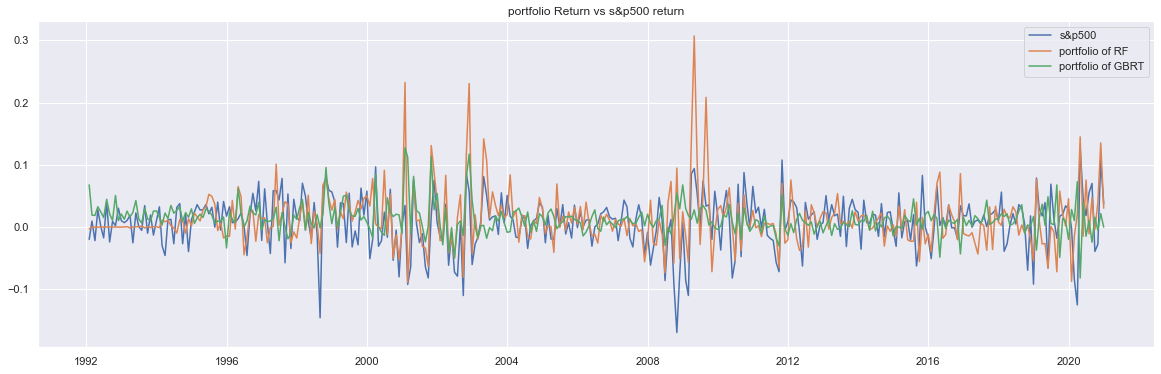

In [134]:
plt.figure(figsize=(20,6))
plt.title('portfolio Return vs s&p500 return')
plt.plot(sp500_m_ret, label='s&p500')
plt.plot(long_short_ports_ret, label='portfolio of RF')
plt.plot(long_short_ports_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

In [149]:
# log-return
log_long_ports_cumu_ret = np.log(long_ports_ret+1).cumsum() 
log_short_ports_cumu_ret = np.log(short_ports_ret+1).cumsum() 
log_long_short_cumu_ret = np.log(long_short_ports_ret+1).cumsum() 
log_sp500_m_cumu_ret = np.log(sp500_m_ret+1).cumsum() 

log_long_ports_cumu_ret_gbrt = np.log(long_ports_ret_gbrt+1).cumsum() 
log_short_ports_cumu_ret_gbrt = np.log(short_ports_ret_gbrt+1).cumsum() 
log_long_short_cumu_ret_gbrt = np.log(long_short_ports_ret_gbrt+1).cumsum() 

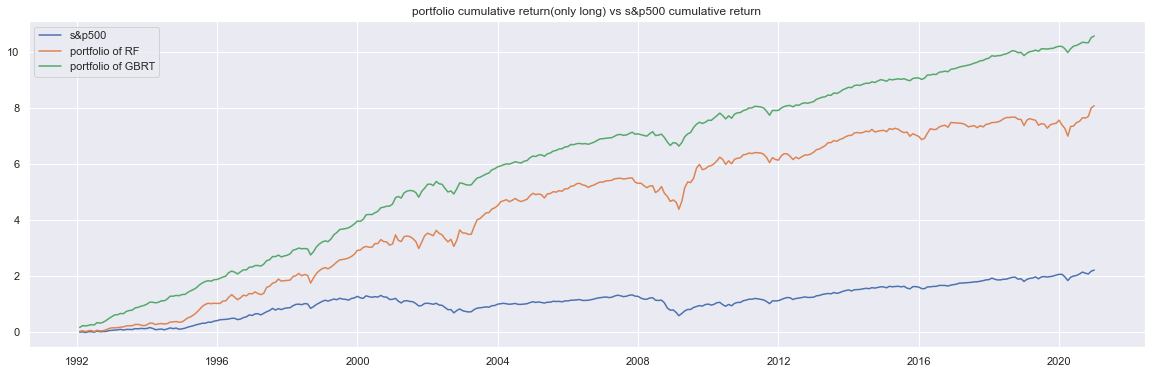

In [150]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return(only long) vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_long_ports_cumu_ret, label='portfolio of RF')
plt.plot(log_long_ports_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

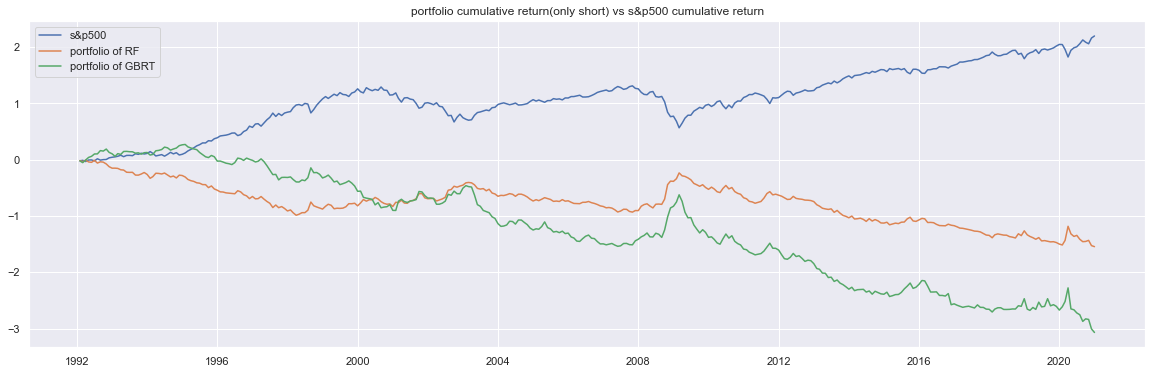

In [152]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return(only short) vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_short_ports_cumu_ret, label='portfolio of RF')
plt.plot(log_short_ports_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

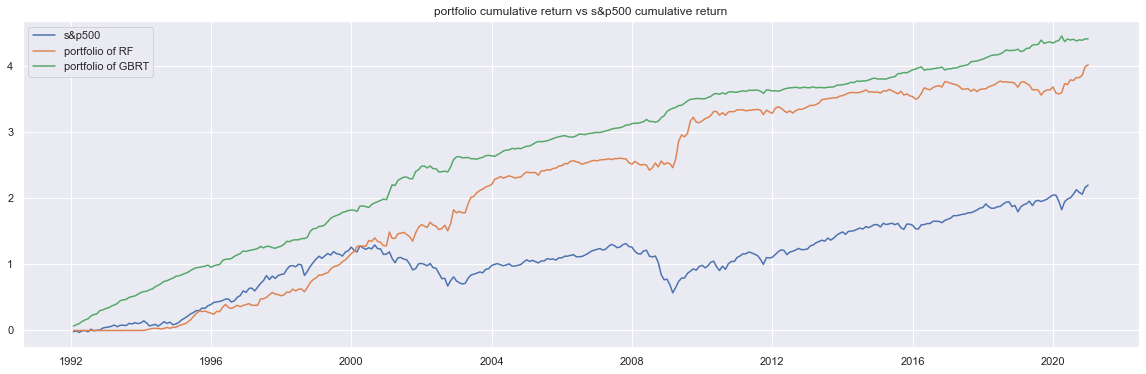

In [151]:
plt.figure(figsize=(20,6))
plt.title('portfolio cumulative return vs s&p500 cumulative return')
plt.plot(log_sp500_m_cumu_ret, label='s&p500')
plt.plot(log_long_short_cumu_ret, label='portfolio of RF')
plt.plot(log_long_short_cumu_ret_gbrt, label='portfolio of GBRT')
plt.legend()
plt.show()

###  Compute Accuracy

In [159]:
tp_df = pred_ave_ret_df.copy()
tp_df['ret'] = real_ret_df['ret']

In [160]:
tp_df

,permno,ret_ave,ret
date,,,
1992-01-31,18921,0.018202,-0.043182
1992-01-31,24942,0.018202,0.028571
1992-01-31,46228,0.018202,-0.153846
1992-01-31,14154,0.018202,-0.037500
1992-01-31,91380,0.018202,-0.033962
...,...,...,...
2020-12-31,60986,0.023004,-0.001411
2020-12-31,21207,0.023441,0.024991
2020-12-31,57665,0.024636,0.052301


In [162]:
import heapq
# for each month, lable top-30% return stock as 1, middle as 0, and bottom-30% return as -1 based on real return
date_list = tp_df.index.drop_duplicates()
tp_df_result_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = tp_df[tp_df.index == i]
    df=df.assign(type = '')
    real_y_list = df['ret'].to_list()
    
    top = heapq.nlargest(round(0.3 * len(real_y_list)), real_y_list)
    bottom = heapq.nsmallest(round(0.3 * len(real_y_list)), real_y_list)
    
    for j in range(len(df['ret'])):
        if df.iloc[j,df.columns.get_loc('ret')] in top:
            df.iloc[j,df.columns.get_loc('type')] = 1
        elif df.iloc[j,df.columns.get_loc('ret')] in bottom:
            df.iloc[j,df.columns.get_loc('type')] = -1
        else:
            df.iloc[j,df.columns.get_loc('type')] = 0
            
    tp_df_result_adj = tp_df_result_adj.append(df)

  0%|                                                   | 0/348 [00:00<?, ?it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
  1%|▏                                          | 2/348 [00:00<00:24, 14.17it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
  8%|███▍                                      | 28/348 [00:01<00:20, 15.87it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
  9%|███▌                                      | 30/348 [00:01<00:20, 15.75it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 16%|██████▌                                   | 54/348 [00:03<00:19, 15.33it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 16%|██████▊                                   | 56/348 [00:03<00:19, 15.27it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 24%|█████████▉                                | 82/348 [00:05<00:17, 14.98it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 24%|██████████▏                               | 84/348 [00:05<00:17, 14.92it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 32%|████████████▉                            | 110/348 [00:07<00:14, 15.87it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 32%|█████████████▏                           | 112/348 [00:07<00:14, 16.04it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 39%|████████████████                         | 136/348 [00:08<00:12, 16.67it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 40%|████████████████▎                        | 138/348 [00:08<00:12, 16.56it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 47%|███████████████████▎                     | 164/348 [00:10<00:11, 16.62it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 48%|███████████████████▌                     | 166/348 [00:10<00:11, 16.47it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 55%|██████████████████████▍                  | 190/348 [00:11<00:09, 16.53it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 55%|██████████████████████▌                  | 192/348 [00:12<00:09, 16.53it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 63%|█████████████████████████▋               | 218/348 [00:13<00:07, 17.64it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 63%|█████████████████████████▉               | 220/348 [00:13<00:07, 17.51it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 70%|████████████████████████████▋            | 244/348 [00:15<00:05, 18.30it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 71%|████████████████████████████▉            | 246/348 [00:15<00:05, 18.33it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 78%|████████████████████████████████         | 272/348 [00:16<00:04, 18.50it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 79%|████████████████████████████████▎        | 274/348 [00:16<00:03, 18.67it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

 86%|███████████████████████████████████      | 298/348 [00:17<00:02, 19.45it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 86%|███████████████████████████████████▎     | 300/348 [00:17<00:02, 19.45it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000g

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
 94%|██████████████████████████████████████▌  | 327/348 [00:19<00:01, 19.78it/s]/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tp_df_result_adj = tp_df_result_adj.append(df)
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_35899/2422034387.py:22: FutureWarning: The frame.append method is 

In [163]:
tp_df_result_adj

,permno,ret_ave,ret,type
date,,,,
1992-01-31,18921,0.018202,-0.043182,-1
1992-01-31,24942,0.018202,0.028571,0
1992-01-31,46228,0.018202,-0.153846,-1
1992-01-31,14154,0.018202,-0.037500,-1
1992-01-31,91380,0.018202,-0.033962,0
...,...,...,...,...
2020-12-31,60986,0.023004,-0.001411,-1
2020-12-31,21207,0.023441,0.024991,0
2020-12-31,57665,0.024636,0.052301,0


In [165]:
# build long and shor portfolio, long top 100 stock and short bottom 100 each month based on predicted return 
long_portfolio = tp_df_result_adj.groupby(level='date').apply(lambda x: x.sort_values('ret_ave', ascending=False).head(100))
short_portfolio = tp_df_result_adj.groupby(level='date').apply(lambda x: x.sort_values('ret_ave', ascending=True).head(100))

long_portfolio = long_portfolio.reset_index(level=0, drop=True)
short_portfolio = short_portfolio.reset_index(level=0, drop=True)

In [166]:
# check stock allocation accuracy for long portfolio 
print(f"The probability of a top stock been allocated in a long portfolio: {sum(long_portfolio['type']==1) / len(long_portfolio)}")
print(f"The probability of a middle stock been allocated in a long portfolio: {sum(long_portfolio['type']==0) / len(long_portfolio)}")
print(f"The probability of a bottom stock been allocated in a long portfolio: {sum(long_portfolio['type']==-1) / len(long_portfolio)}")

The probability of a top stock been allocated in a long portfolio: 0.37775862068965516
The probability of a middle stock been allocated in a long portfolio: 0.2654022988505747
The probability of a bottom stock been allocated in a long portfolio: 0.35683908045977014


In [167]:
# check stock allocation accuracy for short portfolio 
print(f"The probability of a top stock been allocated in a short portfolio: {sum(short_portfolio['type']==1) / len(short_portfolio)}")
print(f"The probability of a middle stock been allocated in a short portfolio: {sum(short_portfolio['type']==0) / len(short_portfolio)}")
print(f"The probability of a bottom stock been allocated in a short portfolio: {sum(short_portfolio['type']==-1) / len(short_portfolio)}")

The probability of a top stock been allocated in a short portfolio: 0.2314080459770115
The probability of a middle stock been allocated in a short portfolio: 0.47304597701149426
The probability of a bottom stock been allocated in a short portfolio: 0.29554597701149427
